# Cybersecurity Attack Prediction

In this notebook, we build a classifier to identify the Attack Type based on network telemetry.

- Strengths: Random Forest is excellent for "Indicator of Compromise" (IoC) detection because it can handle the non-linear relationships between Ports, Protocols, and Anomaly Scores.

- Strategy: We will convert timestamps into "Hour of Day" and simplify IP addresses to focus on network segments.


Basic Libraries

In [ ]:
# Comment out if already installed
#%pip install pandas numpy matplotlib seaborn scikit-learn

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

1. Load Data

In [2]:
# Security data requires careful cleaning. Raw IPs and raw text payloads cause overfitting if not transformed.

df = pd.read_csv('Data/cybersecurity_attacks.csv')

2. Feature Engineering

In [3]:
# Feature Engineering
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour

if 'Payload Data' in df.columns:
    df['Payload_Len'] = df['Payload Data'].str.len().fillna(0)

df['Src_IP_Prefix'] = df['Source IP Address'].str.split('.').str[0]
df['Alerts/Warnings'] = df['Alerts/Warnings'].fillna('None')

cols_to_drop = [
    'Timestamp', 'Source IP Address', 'Destination IP Address',
    'Payload Data', 'User Information', 'Device Information', 'Geo-location Data'
]
df = df.drop(columns=cols_to_drop, errors='ignore')
df.head()



,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Malware Indicators,Anomaly Scores,Alerts/Warnings,Attack Type,...,Action Taken,Severity Level,Network Segment,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source,Hour,Payload_Len,Src_IP_Prefix
0,31225,17616,ICMP,503,Data,HTTP,IoC Detected,28.67,None,Malware,...,Logged,Low,Segment A,150.9.97.135,Log Data,NaN,Server,6,165,103
1,17245,48166,ICMP,1174,Data,HTTP,IoC Detected,51.50,None,Malware,...,Blocked,Low,Segment B,NaN,Log Data,NaN,Firewall,7,196,78
2,16811,53600,UDP,306,Control,HTTP,IoC Detected,87.42,Alert Triggered,DDoS,...,Ignored,Low,Segment C,114.133.48.179,Log Data,Alert Data,Firewall,8,76,63
3,20018,32534,UDP,385,Data,HTTP,NaN,15.79,Alert Triggered,Malware,...,Blocked,Medium,Segment B,NaN,NaN,Alert Data,Firewall,10,193,163
4,6131,26646,TCP,1462,Data,DNS,NaN,0.52,Alert Triggered,DDoS,...,Blocked,Low,Segment C,149.6.110.119,NaN,Alert Data,Firewall,13,185,71


3. Preprocessing & Split

In [4]:
# Target Encoding
target_col = 'Attack Type'
le = LabelEncoder()
y = le.fit_transform(df[target_col])
class_names = le.classes_
X = df.drop(target_col, axis=1)

# Pipeline Setup
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
])

pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(random_state=42, class_weight='balanced_subsample', n_jobs=-1))
])


4. Build & Tune Model

In [5]:
# Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

param_grid = {
    'model__n_estimators': [100], # Reduced for speed
    'model__max_depth': [10, 15]
}

grid = GridSearchCV(pipe, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Source '
                                                                          'Port',
                                                                          'Destination '
                                                                          'Port',
                                                                          'Packet '
                                                                          'Length',
                                                                          'Anomaly '
                                                                          'Scores',
                                                                          'Payload_Len']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Protocol',
                                                                          'Packet '
                                                                          'Type',
                                                                          'Traffic '
                                                                          'Type',
                                                                          'Malware '
                                                                          'Indicators',
                                                                          'Aler...
                                                                          'Signature',
                                                                          'Action '
                                                                          'Taken',
                                                                          'Severity '
                                                                          'Level',
                                                                          'Network '
                                                                          'Segment',
                                                                          'Proxy '
                                                                          'Information',
                                                                          'Firewall '
                                                                          'Logs',
                                                                          'IDS/IPS '
                                                                          'Alerts',
                                                                          'Log '
                                                                          'Source',
                                                                          'Src_IP_Prefix'])])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced_subsample',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 15],
                         'model__n_estimators': [100]},
             scoring='f1_macro', verbose=1)

5. Evaluation & Threat Intel

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



**Cyber-Threat Classification Report:**

              precision    recall  f1-score   support

        DDoS       0.33      0.32      0.33      2686
   Intrusion       0.33      0.34      0.33      2653
     Malware       0.32      0.32      0.32      2661

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000



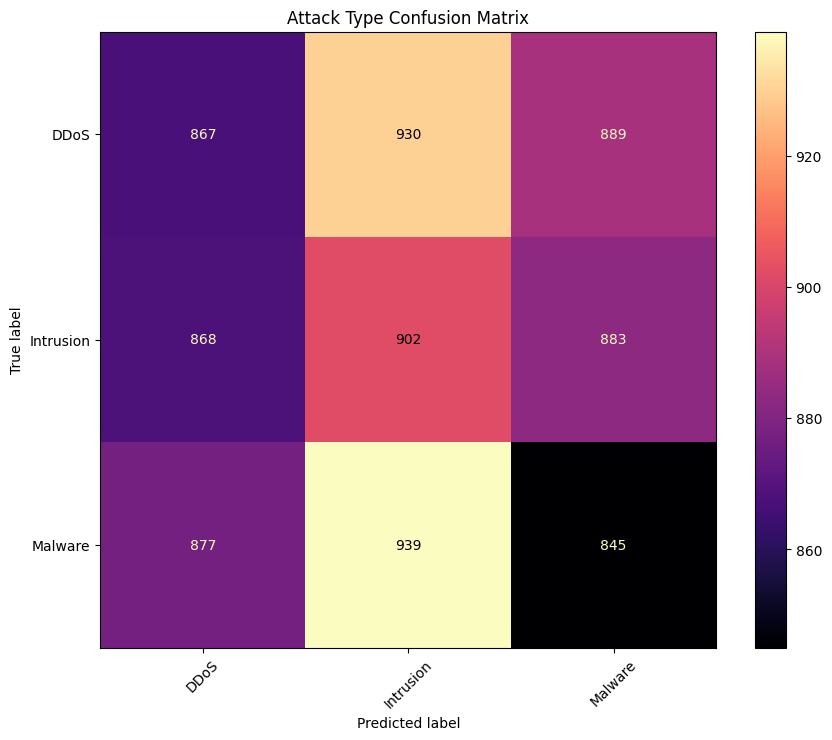

In [6]:
# --- Reporting ---
y_pred = grid.predict(X_test)
print("\n**Cyber-Threat Classification Report:**\n")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
fig_cm, ax_cm = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_names,
                                        xticks_rotation=45, cmap='magma', ax=ax_cm)
plt.title('Attack Type Confusion Matrix')
plt.show()

## Critical CyberSecurity Insights

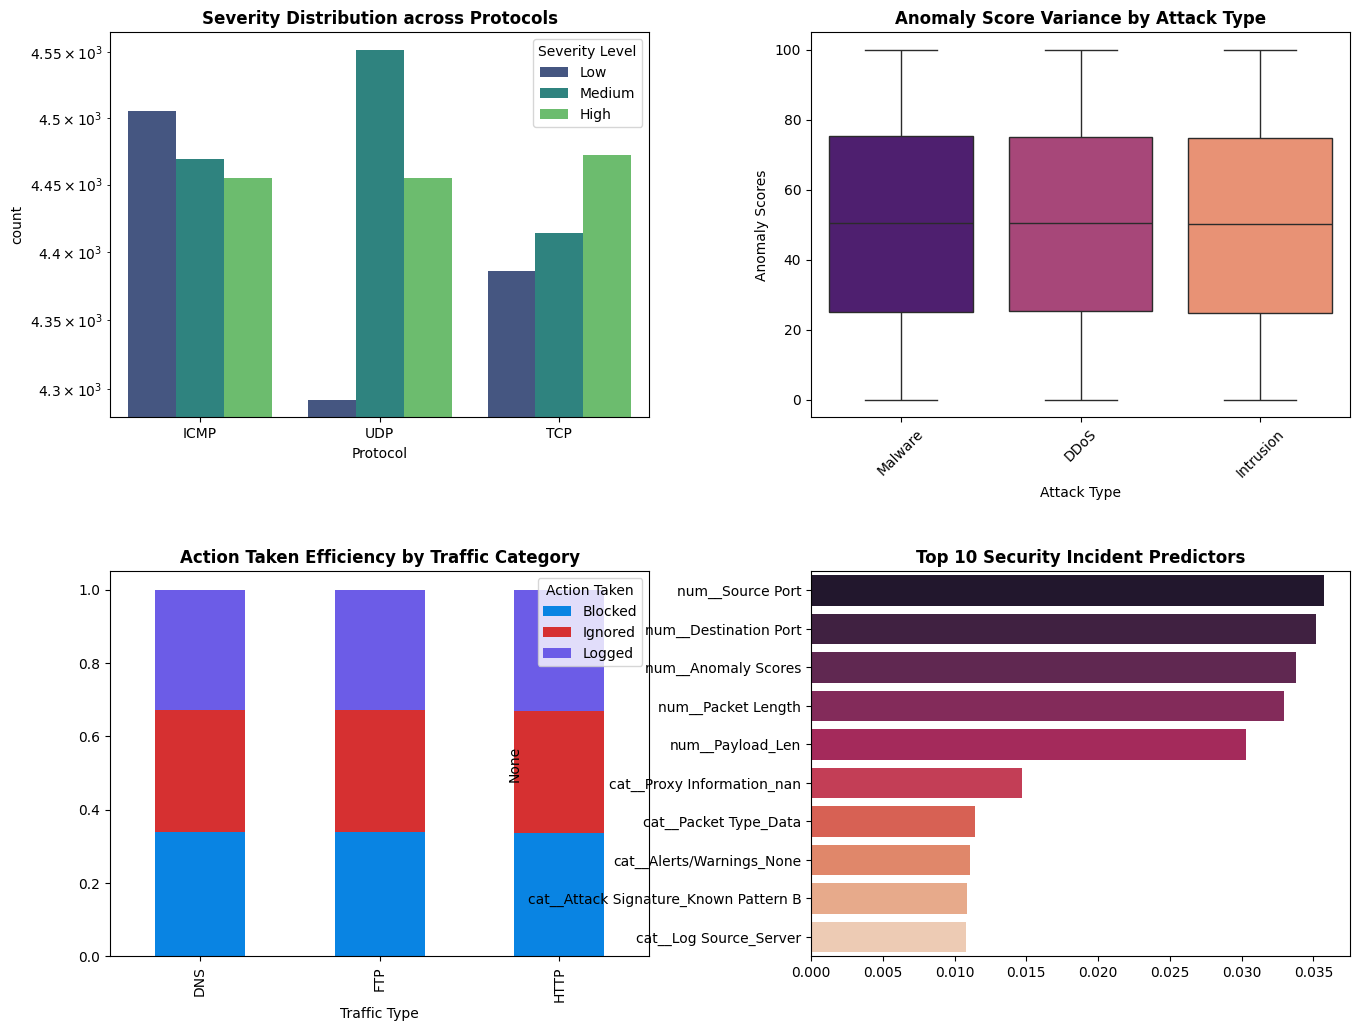

In [7]:
# --- Advanced Visualizations ---
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1. Severity Distribution
sns.countplot(data=df, x='Protocol', hue='Severity Level', ax=ax[0,0], palette='viridis')
ax[0,0].set_title('Severity Distribution across Protocols', fontsize=12, fontweight='bold')
ax[0,0].set_yscale('log')

# 2. Anomaly Score Variance
sns.boxplot(data=df, x='Attack Type', y='Anomaly Scores', hue='Attack Type',
            ax=ax[0,1], palette='magma', legend=False)
ax[0,1].set_title('Anomaly Score Variance by Attack Type', fontsize=12, fontweight='bold')
ax[0,1].tick_params(axis='x', rotation=45)

# 3. Action Taken Efficiency
action_counts = pd.crosstab(df['Traffic Type'], df['Action Taken'], normalize='index')
action_counts.plot(kind='bar', stacked=True, ax=ax[1,0], color=['#0984e3', '#d63031', '#6c5ce7'])
ax[1,0].set_title('Action Taken Efficiency by Traffic Category', fontsize=12, fontweight='bold')

# 4. Feature Importance (The Fix)
importances = grid.best_estimator_.named_steps['model'].feature_importances_
feature_names = grid.best_estimator_.named_steps['preprocess'].get_feature_names_out()
fi_series = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10)

sns.barplot(x=fi_series.values, y=fi_series.index, hue=fi_series.index,
            ax=ax[1,1], palette='rocket', legend=False)
ax[1,1].set_title('Top 10 Security Incident Predictors', fontsize=12, fontweight='bold')

plt.show()

### Interpreting the Visual Insights

1. Severity by Protocol: If you see a high concentration of "High Severity" attacks on ICMP, it likely indicates a Ping-of-Death or reconnaissance attempt. Most normal traffic is TCP/UDP, so ICMP spikes are immediate red flags.

2. Anomaly Distribution: This boxplot shows the "threshold" for a threat. If Malware has a median anomaly score of 80+, while "Normal" traffic is below 30, you can use this to set automated firewall blocking rules.

3. Action Taken Efficiency: This is a "gap analysis." If the chart shows a large blue bar (Logged) for Malware instead of a red bar (Blocked), your security posture needs to be tightened.

4. Top Predictors: This tells the SOC team which data points to monitor. If Destination Port is the #1 predictor, it suggests that attackers are scanning for specific vulnerabilities (like open RDP or Database ports).

# Conclusion: Intelligence-Driven Defense

By deploying this Random Forest model, we have transformed raw logs into a proactive Intrusion Detection System. Unlike traditional signature-based detection which only catches "known" threats, this model uses Anomaly Scores and Traffic Patterns to identify zero-day behaviors.

Key Takeaways:

- Time-Based Patterns: By extracting the Hour from timestamps, the model can identify "out-of-hours" data exfiltration.

- Payload Analysis: Even without reading the encrypted content, the Payload_Len serves as a proxy for identifying buffer overflow attacks or hidden tunneling.

- Automated Response: This model provides the statistical backing to move from "Logging" to "Automated Blocking," drastically reducing the mean time to respond (MTTR).